In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
import joblib
import multiprocessing


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [ ]:
#leer datos
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
curva = pd.read_csv('CurvasExpT8.csv')

In [ ]:
#entradas.shape

In [ ]:
#salidas.shape

In [ ]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
#X_train, X_test, y_train, y_test = train_test_split(entradas,salidas, test_size=0.20)

In [ ]:
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RandomForestRegressor(criterion='mse', n_estimators=10, n_jobs=-1,
                      random_state=123)

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.1196890268557649


In [ ]:
# R2 de test del modelo inicial
# ==============================================================================
predicciones_test=modelo.predict(X_test)
r2_test = r2_score(y_test,predicciones_test)
print("El r2 de tu modelo en validación es:", r2_test)

El r2 de tu modelo en validación es: 0.7387928650339924


In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [10,30,50, 80, 120, 150, 180, 200],
              'max_leaf_nodes': [50, 70, 100, 120, 150, 180, 200],
              'max_depth'   : [3, 10, 15, 20,25],
              'min_samples_split': [2,3,4]
             }
#Iniciamos a contar tiempo
inicio = time.time()
# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)
fin=time.time()
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)


,param_max_depth,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
487,15,200,2,200,-0.122226,0.008920,-0.045358,0.000894
655,20,200,2,200,-0.122228,0.008914,-0.045358,0.000896
823,25130,200,2,200,-0.122228,0.008914,-0.045358,0.000896
486,15,200,2,180,-0.122317,0.008852,-0.045338,0.000892
654,20,200,2,180,-0.122319,0.008845,-0.045338,0.000893
822,25130,200,2,180,-0.122319,0.008845,-0.045338,0.000893
463,15,180,2,200,-0.122365,0.008908,-0.045555,0.000900
631,20,180,2,200,-0.122369,0.008902,-0.045555,0.000902
799,25130,180,2,200,-0.122369,0.008902,-0.045555,0.000902
462,15,180,2,180,-0.122453,0.008840,-0.045537,0.000896


In [ ]:
print("El tiempo del RF fue de:",fin-inicio)

El tiempo del RF fue de: 5222.5504512786865


In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 15, 'max_leaf_nodes': 200, 'min_samples_split': 2, 'n_estimators': 200} : -0.122226063455419 neg_root_mean_squared_error


In [ ]:
modelo_final = grid.best_estimator_

In [ ]:
# Error de test del modelo final

predicciones = modelo_final.predict(X = X_train)
rmse = mean_squared_error(
        y_true  = y_train,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de train es: {rmse}")

El error (rmse) de train es: 0.04468891037261392


In [ ]:
# R2 de test del modelo final
# ==============================================================================
predicciones_train=modelo_final.predict(X_train)
r2_train = r2_score(y_train,predicciones_train)
print("El r2 de tu modelo en entrenamiento es:", r2_train)

El r2 de tu modelo en entrenamiento es: 0.962152114753823


In [ ]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.11138523350205853


In [ ]:
predicciones_test=modelo_final.predict(X_test)
r2_test = r2_score(y_test,predicciones_test)
print("El r2 de tu modelo en validación es:", r2_test)

El r2 de tu modelo en validación es: 0.7690913073916045


In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
120,ID121,0.241891
119,ID120,0.060047
118,ID119,0.034293
117,ID118,0.030732
116,ID117,0.027691
...,...,...
36,ID37,0.000000
35,ID36,0.000000
34,ID35,0.000000
33,ID34,0.000000


In [ ]:
#Convertir a valores numéricos de numpy
X_train = np.matrix(X_train)
X_test = np.matrix(X_test)
y_train = np.matrix(y_train)
y_test = np.matrix(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


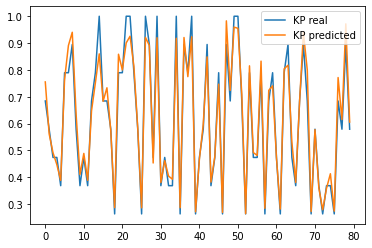

In [ ]:
plt.plot(y_test[0:80,0], label='KP real')
plt.plot(modelo_final.predict(X_test)[0:80,0], label='KP predicted')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


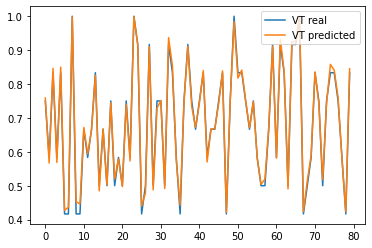

In [ ]:
plt.plot(y_test[0:80,1], label='VT real')
plt.plot(modelo_final.predict(X_test)[0:80,1], label='VT predicted')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


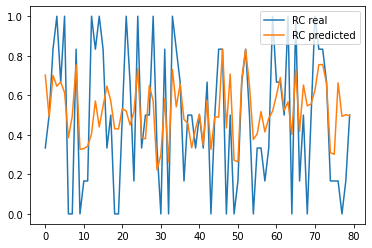

In [ ]:
plt.plot(y_test[0:80,2], label='RC real')
plt.plot(modelo_final.predict(X_test)[0:80,2], label='RC predicted')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


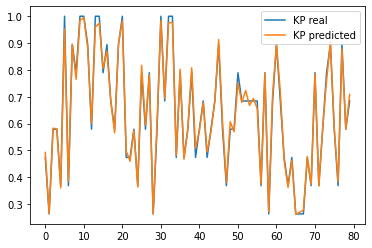

In [ ]:
plt.plot(y_train[0:80,0], label='KP real')
plt.plot(modelo_final.predict(X_train)[0:80,0], label='KP predicted')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


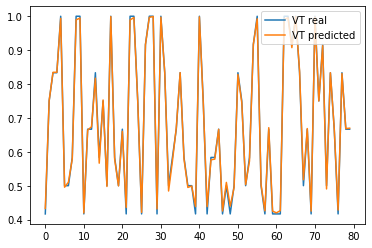

In [ ]:
plt.plot(y_train[0:80,1], label='VT real')
plt.plot(modelo_final.predict(X_train)[0:80,1], label='VT predicted')
plt.legend(loc='upper right')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


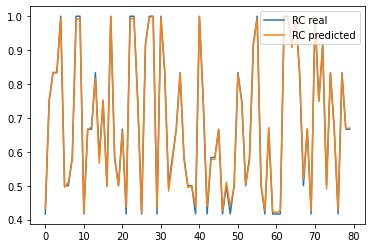

In [ ]:
plt.plot(y_train[0:80,1], label='RC real')
plt.plot(modelo_final.predict(X_train)[0:80,1], label='RC predicted')
plt.legend(loc='upper right')
plt.show()

In [ ]:
salidaForest=modelo_final.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
#Convertir a valores numéricos de numpy
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
#--------------------------------------------------
#Cargamos por separado los datos
UOreal = (y_test)[:,0]
UOnet =(salidaForest)[:,0]
VTreal = (y_test)[:,1]
VTnet = (salidaForest)[:,1]
RCreal=(y_test)[:,2]
RCnet = (salidaForest)[:,2]

In [ ]:
#---------------------------------------------
#MSE de UO
rmse = mean_squared_error(
        y_true  = UOreal,
        y_pred  = UOnet,
        squared = False
       )
print(f"El error (rmse) de UO es: {rmse}")

El error (rmse) de UO es: 0.04698414788961353


In [ ]:
#---------------------------------------------
#R2 de UO 
r2_netUO = r2_score(UOreal,UOnet)
print("El r2 de la red para UO es:", r2_netUO)

El r2 de la red para UO es: 0.9621976361155938


In [ ]:
#---------------------------------------------
#MSE de VT 
rmse = mean_squared_error(
        y_true  = VTreal,
        y_pred  = VTnet,
        squared = False
       )
print(f"El error (rmse) de VT es: {rmse}")

El error (rmse) de VT es: 0.012708031227218109


In [ ]:
#---------------------------------------------
#R2 de VT 
r2_netVT = r2_score(VTreal,VTnet)
print("El r2 de la red para VT es:", r2_netVT)

El r2 de la red para VT es: 0.9947936244076205


In [ ]:
#---------------------------------------------
#MSE de RC 
rmse = mean_squared_error(
        y_true  = RCreal,
        y_pred  = RCnet,
        squared = False
       )
print(f"El error (rmse) de RC es: {rmse}")

El error (rmse) de RC es: 0.274463521389344


In [ ]:
#---------------------------------------------
#R2 de RC 
r2_netRC = r2_score(RCreal,RCnet)
print("El r2 de la red para RC es:", r2_netRC)

El r2 de la red para RC es: 0.3502826616515986


In [ ]:
salidaForest_test=pd.DataFrame(salidaForest)
salidaForest_test.reset_index().to_csv('salidas_ForestT8.csv',header=True,index=False)
#Out_traindf=pd.DataFrame(y_train)
#In_testdf=pd.DataFrame(X_test)
#Out_testdf=pd.DataFrame(y_test)
#Out_traindf.reset_index().to_csv('Out_train.csv',header=True,index=False)
#In_testdf.reset_index().to_csv('In_test.csv',header=True,index=False)
#Out_testdf.reset_index().to_csv('Out_test.csv',header=True,index=False)

In [ ]:
joblib.dump(modelo_final,'random_forestT8.pkl')

['random_forestT8.pkl']

In [ ]:
salida = modelo_final.predict(curva)

In [ ]:
salidadf=pd.DataFrame(salida)
salidadf.reset_index().to_csv('salCurvexpT8.csv',header=True,index=False)